# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Porto Seguro’s Safe Driver Prediction - Kaggle</p>

## Predict if a driver will file an insurance claim next year

<img src='./img/safe-driving-730x432.jpeg' style='height:400px; border-radius: 5px;'/>

---
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Contents:</p>

* [1. Introduction](#1)
    * [1.1 Data Description](#1.1)
    * [1.2 Libraries](#1.2)
    * [1.3 Loading Dataset](#1.3)
* [2. Preprocessing & Feature Engineering](#2)
    * [2.1 SMOTE](#2.1)
    * [2.2 Cross-validation](#2.2)
    * [2.3 Feature Selection](#2.3)
* [3. Models](#3)
    * [3.1 Lightgbm](#3.1)
    * [3.2 Neural Networks](#3.2)
* [4. Evaluation](#4)
* [5. Kaggle Submission](#5)

<a id="1"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">1- Introduction</p>

<img title="Porto Seguro" src="img/porto-seguro-logo-1-3.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px;' align="center"> 

[Porto Seguro](https://www.portoseguro.com.br/en/institutional) is one of the largest insurance companies in Brazil specialized in car and home insurance. Located in São Paulo, Porto Seguro has been one of the leading insurers in Brazil since its foundation in 1945.

A key challenge faced by all major insurers is, when it comes to car insurance, how to address fairness towards good drivers and try not to penalize those who have a good driving history on account of a few bad drivers. Inaccuracies in car insurance claim predictions usually raise its cost for good drivers and reduce the price for bad ones.

Porto Seguro has been applying Machine Learning for more than 20 years and intends to make car insurance more accessible to everyone. Thinking about that, the company created an online competition to help them explore new and more powerful ML methods.

<img title="Porto Seguro" src="img/Kaggle_logo.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px' align="center">

[Kaggle](https://www.kaggle.com/) is an online community of data scientists and allows users to find and publish data sets, explore and build ML models, and enter competitions to solve data science challenges.

In this [competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/), the challenge is build a model that predicts the probability that a car insurance policy holder will file a claim next year.

<a id="1.1"></a>
## Data Description

In the train and test data:

- Features that belong to similar groupings are tagged as such in the feature names (e.g., `ind`, `reg`, `car`, `calc`). 
- Feature names include the postfix `bin` to indicate binary features and `cat` to indicate categorical features.
- Features __without__ these designations are either __continuous or ordinal__.
- Values of `-1` indicate that the feature was missing from the observation. 
- The `target` columns signifies whether or not a claim was filed for that policy holder. 

- `ind` - individuals
- `reg` - regions
- `car` - cars
- `calc` - calculated features

- `_bin` - binary 
- `_cat` - categorical

<a id="1.2"></a>
## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random
import json

%matplotlib inline
matplotlib.style.use("ggplot")

# Preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from lightgbm import LGBMClassifier
import joblib

# Evaluation
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV

import time
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.8.5


In [3]:
# !pip install -q -U watermark
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

sklearn   : 0.23.2
matplotlib: 3.3.2
pandas    : 1.1.3
seaborn   : 0.11.1
joblib    : 1.0.1
numpy     : 1.19.2
lightgbm  : 3.1.1



<a id="1.3"></a>
## Loading Dataset

In [4]:
# Kaggle
#path = "../input/porto-seguro-safe-driver-prediction/"

# Local
path = "./data/"

In [5]:
%%time
train_df = pd.read_csv(path + "train.csv").set_index('id')
test_df = pd.read_csv(path + "test.csv").set_index('id')

CPU times: user 8.1 s, sys: 1.71 s, total: 9.81 s
Wall time: 10.4 s


---
As per description, there are a few calculated features. In one of the discussions on Kaggle, it was highlighted that some kind of transformation was applied in order to generate these features. I will drop these features and apply the transformations using my best judgment.

In [6]:
train_df = train_df.drop(train_df.filter(regex='_calc').columns, axis=1)
test_df = test_df.drop(test_df.filter(regex='_calc').columns, axis=1)

In [7]:
print('Train Dataset - Number of rows are',train_df.shape[0], 'and number of columns are ',train_df.shape[1])
print('Test Dataset - Number of rows are',test_df.shape[0], 'and number of columns are ',test_df.shape[1])

Train Dataset - Number of rows are 595212 and number of columns are  38
Test Dataset - Number of rows are 892816 and number of columns are  37


<a id="2"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">2- Preprocessing & Feature Engineering</p>

## Target variable distribution

`target` variable 1 means that a claim was filed and 0 that it was not claimed.

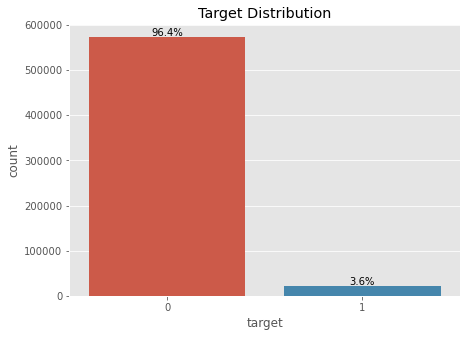

In [8]:
y = train_df.target
fig = plt.figure(figsize=(7, 5))
ax = sns.countplot(y,label="Count")

total_size = len(train_df)

# Display the target value ratio at the top of the bar
for patch in ax.patches:
    height = patch.get_height()
    width = patch.get_width()
    left_coord = patch.get_x()
    percent = height/total_size*100

    ax.text(x=left_coord + width/2.0, 
            y=height + 3000,
            s='{:1.1f}%'.format(percent),
            ha='center')

ax.set_title('Target Distribution');
plt.savefig('./plots/target_distribution.png', dpi=fig.dpi)

---
The target feature has a severe __imbalance distribution__ showing that only __3.6% filled a claim__ and 96.4% did not.

This will be handle by the algorithm through a hyperparameter `is_unbalance = True`.

## Missing values

Values of __`-1`__ indicate that the feature was missing from the observation.

In [9]:
vars_with_missing = []

for f in train_df.columns:
    missings = train_df[train_df[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train_df.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('\nIn total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values

In total, there are 13 variables with missing values


---
Only `ps_car_03_cat` and `ps_car_05_cat` have a large number (~ >= 50%) of missing values.
- ps_car_03_cat has 411231 records (69.09%)
- ps_car_05_cat has 266551 records (44.78%)

There are several ways to __deal with missing data__ such as __Mean Imputation__, __Interpolation__ and __Extrapolation__. I will address this issue later on.

<a id="2.1"></a>
## Metadata

To make data management easier, a meta-info about the variables is added to the DataFrame. It will help handling those variables later on the analysis, data viz and modeling.

- __level__: categorical, numerical, binary
- __dtype__: int, float, str

We do not have information on which features are ordinal or not so a meta-info `numerical` will be added in order to apply __Normalization__ later.

In [10]:
data = []
for f in train_df.columns:
    
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f:
        level = 'categorical'
    elif train_df[f].dtype == float:
        level = 'numerical'
    elif train_df[f].dtype == int:
        level = 'numerical'
    
    # Defining the data type 
    dtype = train_df[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'level': level,
        'dtype': dtype
    }
    
    data.append(f_dict)

In [11]:
meta = pd.DataFrame(data, columns=['varname', 'level', 'dtype'])
meta.set_index('varname', inplace=True)

In [12]:
# Example to extract all categorical variables that are not dropped
meta[(meta.level == 'categorical')].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

### Number of variables per role and level 

In [13]:
pd.DataFrame({'count' : meta.groupby(['level'])['level'].size()}).reset_index()

,level,count
0,binary,12
1,categorical,14
2,numerical,12


## Exploratory Analysis

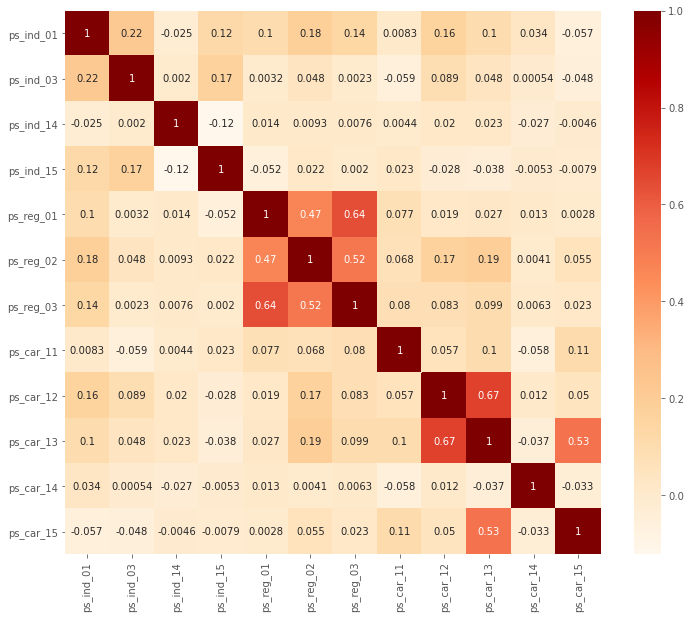

In [14]:
numerical_features = meta[(meta.level == 'numerical')].index
fig = plt.figure(figsize=(12, 10))
cont_corr = train_df[numerical_features].corr() # Correlation between continuous features
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # Plot heatmap
plt.savefig('./plots/heatmap.png', dpi=fig.dpi)

There are a strong correlations between the variables:

- ps_car_12 and ps_car_13 (0.67)
- ps_reg_01 and ps_reg_03 (0.64)
- ps_reg_02 and ps_reg_03 (0.52)

Heatmap showed low number of correlated variables, we'll look at each of the highly correlated variables separately.

In [15]:
# Convert -1 from training data copy to np.NaN
train_copy = train_df.copy().replace(-1, np.NaN)
train_copy = train_copy.dropna()
s = train_copy.sample(frac=0.1)

__NOTE__: sampling was applied to speed up the process.

### ps_car_12 x ps_car_13

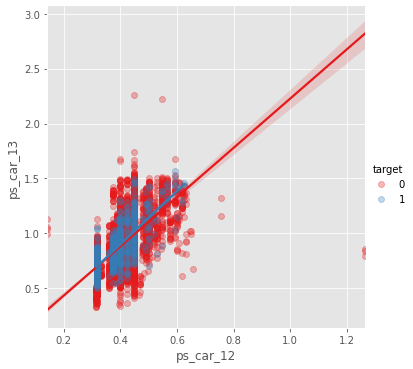

In [16]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_car_12xps_car_13.png', dpi=fig.dpi)
plt.show()

### ps_reg_01 x ps_reg_03

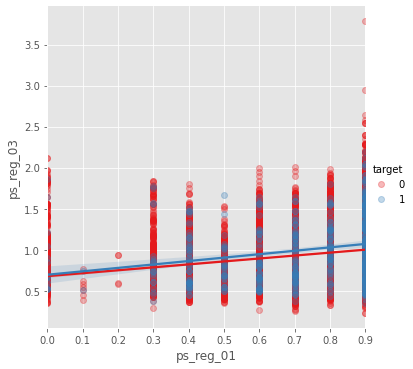

In [17]:
sns.lmplot(x='ps_reg_01', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_reg_01xps_reg_03.png', dpi=fig.dpi)
plt.show()

### ps_reg_02 x ps_reg_03

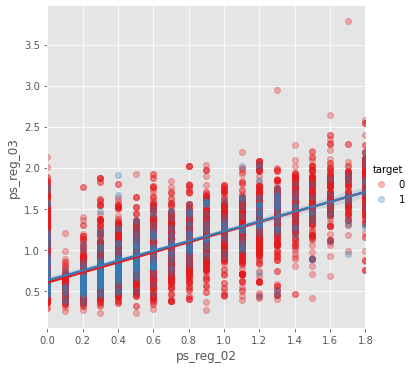

In [18]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_reg_02xps_reg_03.png', dpi=fig.dpi)
plt.show()

As the number of correlated variables is rather low, dimensionality reduction will not be applied and the model will do the heavy-lifting.

## Binary features

__Distribution__ of binary data and the __corresponding__ values of __target__ variable.

<Figure size 432x288 with 0 Axes>

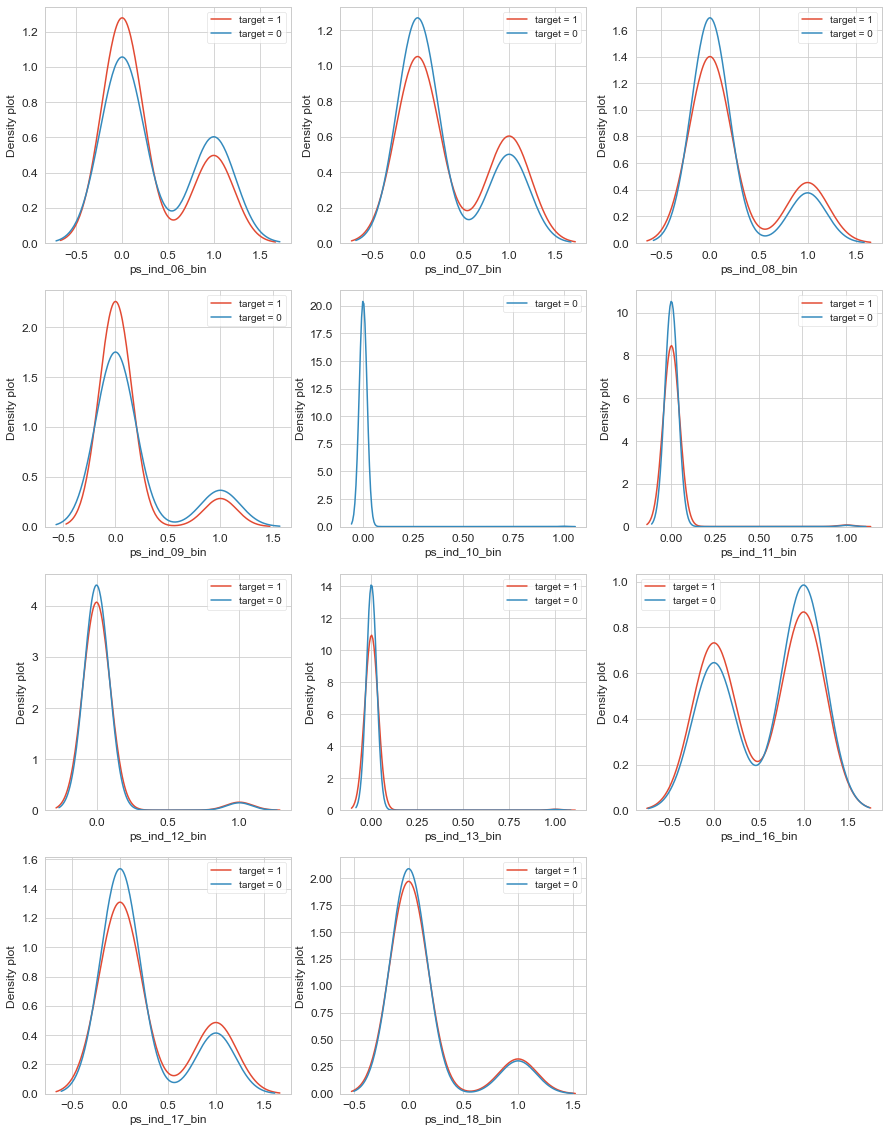

In [19]:
warnings.simplefilter(action='ignore')
var = [col for col in train_copy.columns if '_bin' in col]
i = 0

s_bin = train_copy.sample(frac=0.1)
t1 = s_bin.loc[s_bin['target'] != 0]
t0 = s_bin.loc[s_bin['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(figsize=(15,20))

for feature in var:
    i += 1
    plt.subplot(4,3,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.legend(loc='best')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

#plt.savefig('./plots/binary-features.png', dpi=fig.dpi)
plt.show()

<a id="2.2"></a>
## Feature Importance

As the categorical variables are already numerical, there is no need to apply LabelEncoding.

__Reference__:
>Raschka, S., & Mirjalili, V. (2019). Python Machine Learning. Zaltbommel, Netherlands: Van Haren Publishing.

In [20]:
# Feature scaling
numerical_features = meta[(meta.level == 'numerical')].index
features_n = numerical_features.to_list()
training_normalized = train_df.copy()

features = training_normalized[features_n]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

training_normalized[features_n] = features

In [21]:
training_data = training_normalized.copy()

In [22]:
lgb_params_f = {
        'is_unbalance': True, # because training data is extremely unbalanced
        'objective': 'binary',
        'boosting_type': 'dart',
        'learning_rate': 0.01,
        'n_estimators': 250,
        'n_jobs': 2, # number of parallel threads
        'importance_type': 'gain'
    }
features_classifier = lgb.LGBMClassifier()
features_classifier.set_params(**lgb_params_f)

LGBMClassifier(boosting_type='dart', importance_type='gain', is_unbalance=True,
               learning_rate=0.01, n_estimators=250, n_jobs=2,
               objective='binary')

__StratifiedKFold__: This method should be used in situations when we have a very unbalanced class.

- __'objective': 'binary'__ is because it is a classification problem

- __'learning_rate'__ Step size shrinkage used in update to prevents overfitting. After each boosting step, we can diresctly get the weights of new features. Learning rate shrinks the feature weights to make the boosting process more conservative.

- __'boosting_type'__ gbdt suffers from over-specialization, which means trees added at later iterations tend to impact the prediction of only a few instances and make a negligible contribution towards the remaining instances. Adding dropout makes it more difficult for the trees at later iterations to specialize on those few samples and hence improves the performance. For this reason I am using __DART (Dropouts meet Multiple Additive Regression Trees)__ as boosting type.

>Rashmi, K. V., & Gilad-Bachrach, R. (2015). DART: Dropouts meet Multiple Additive Regression Trees. ArXiv.

- __'n_estimators__ Number of boosted trees to fit.
- __'n_jobs': 2__ for speed improvement, set this to the number of real CPU cores, not the number of threads.
- __'importance_type': 'gain'__ result contains total gains of splits which use the feature.


## Combining train and test data

Now that we have the Feature Importance, let's concat the train and test data in order to perform transformation on both.

In [23]:
all_data = pd.concat([train_df, test_df], ignore_index=True)
all_data = all_data.drop('target', axis=1) # Remove target value

## Dropping less important features

In [24]:
drop_features = ['ps_car_08_cat', 'ps_ind_13_bin','ps_ind_12_bin', 
                 'ps_car_10_cat','ps_ind_10_bin','ps_ind_11_bin', 
                 'ps_ind_14','ps_car_02_cat','ps_car_05_cat', 
                 'ps_ind_08_bin','ps_car_09_cat','ps_ind_02_cat']


all_data_remaining = all_data.drop(drop_features, axis=1)

print('Number of features before selection: {}'.format(all_data.shape[1]))
print('Number of features after selection: {}'.format(all_data_remaining.shape[1]))


Number of features before selection: 37
Number of features after selection: 25


In [25]:
all_data_feat_sel = all_data_remaining.copy()

## Handling missing data

The study of missing data was formalized by Donald Rubin with the concept of missing mechanism in which missing-data indicators are random variables and assigned a distribution. Missing data mechanism describes the underlying mechanism that generates missing data.

It is important to consider missing data mechanism when deciding how to deal with missing data. Because this is unknown, I will consider the missing data as part of the dataset (new category for example) and just create a new feature adding the total number of missing data.

>Rubin, D. B. (1975). INFERENCE AND MISSING DATA. ETS Research Bulletin Series, 1975(1), i–19. https://doi.org/10.1002/j.2333-8504.1975.tb01053.x

In [26]:
feature_names = all_data_feat_sel.columns.tolist()
num_features = [c for c in feature_names if '_cat' not in c]
all_data_feat_sel['missing'] = (all_data_feat_sel==-1).sum(axis=1).astype(float)
num_features.append('missing')

<a id="2.2"></a>
## Feature scaling using StandardScaler

In [27]:
features_n = [col for col in all_data_feat_sel.columns if ('_cat' not in col and '_bin' not in col)]
all_data_n = all_data_feat_sel.copy()

features = all_data_n[features_n]

# using default 
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

all_data_n[features_n] = features

<a id="2.3"></a>
## One-hot encoding categorical features

In [28]:
all_data_enc = all_data_n.copy()
categoricals_features = [col for col in all_data_feat_sel.columns if '_cat' in col]

print('Before dummification we have {} variables in train'.format(all_data_enc.shape[1]))
all_data_enc = pd.get_dummies(all_data_enc, columns=categoricals_features, drop_first=True)
print('After dummification we have {} variables in train'.format(all_data_enc.shape[1]))

Before dummification we have 26 variables in train
After dummification we have 172 variables in train


## Split train and test data 

In [29]:
num_train = train_df.shape[0] # Number of train data 
final_data = all_data_enc.copy()

# Divide train data and test data
X = np.asarray(final_data[:num_train])
X_test = np.asarray(final_data[num_train:])

y = np.asarray(train_df['target'])

<a id="3"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">3- Model</p>

## Gini coefficient - Kaggle Evaluation

![Gini](./img/lorenz-curve.png)

The Gini index or Gini coefficient is a statistical measure of distribution which was developed by the Italian statistician Corrado Gini in 1912. It is used as a gauge of economic inequality, measuring income distribution among a population.

The Gini coefficient is equal to the area below the line of perfect equality (0.5 by definition) minus the area below the Lorenz curve, divided by the area below the line of perfect equality. In other words, it is double the area between the Lorenz curve and the line of perfect equality.

__Reference__:
>https://theblog.github.io/post/gini-coefficient-intuitive-explanation/

In [30]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

## LightGBM

In [32]:
lgb_params = {
        'objective': 'binary',
        'is_unbalance': True, # As we have a severe imbalanced class
        'metric': 'auc',
        'n_jobs': 2,
        'learning_rate': 0.01,
        'num_leaves': 30
    }

## K-fold cross validation

When your data set is not be large enough to slice into three representative parts, cross validation can help with that. K-fold cross validation prevents overfitting to your test data without further reducing the size of your training data set.

K-fold cross validation reports on the performance of a model on several (k) samples from your training set. This provides a less biased evaluation of the model. However, K-fold cross validation is more computationally expensive than slicing your data into three parts. It re-fits the model and tests it k-times, for each iteration, as opposed to one time.

In [33]:
%%time
# One-dimensional array of probabilities for predicting validation data target values
val_preds_lgb = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values
test_preds_lgb = np.zeros(X_test.shape[0])

evals_result = {}

# Create Stratified K Fold CV
folds = StratifiedKFold(n_splits=5, shuffle=True)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx] # Valid data

    # Create lgbm dataset
    dtrain = lgb.Dataset(X_train, y_train) # lgbm train dataset
    dvalid = lgb.Dataset(X_valid, y_valid) # lgbm valid dataset

    lgb_model = lgb.train(params=lgb_params,
                          train_set=dtrain,
                          num_boost_round=1500,
                          valid_sets=[dvalid, dtrain],
                          feval=gini_lgb, # Evaluation metrics for validation
                          early_stopping_rounds=200, 
                          verbose_eval=200, 
                          evals_result=evals_result)
    
    # The number of boosting iterations when the model performs best 
    best_iter = lgb_model.best_iteration
    
    # Predict probabilities using test data
    test_preds_lgb += lgb_model.predict(X_test, 
                                    num_iteration=best_iter)/folds.n_splits
    # prediction for model performance evaluation
    val_preds_lgb[valid_idx] += lgb_model.predict(X_valid, num_iteration=best_iter)
    
    # Normalized Gini coefficient for prediction probabilities
    gini_score = Gini(y_valid, val_preds_lgb[valid_idx])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.66151	training's gini: 0.32302	valid_0's auc: 0.636536	valid_0's gini: 0.273071
[400]	training's auc: 0.673172	training's gini: 0.346343	valid_0's auc: 0.638579	valid_0's gini: 0.277158
Early stopping, best iteration is:
[380]	training's auc: 0.672037	

## Saving the results

In [52]:
# Save LightGBM model to file in the current working directory
lgb_model.save_model('./files/model-gini/LightGBM_Model_gini.txt')

In [53]:
# Save LightGBM model to file in the current working directory

joblib_file = "./files/model-gini/LightGBM_Model_gini.pkl"  
joblib.dump(lgb_model, joblib_file)

['./files/model-gini/LightGBM_Model_gini.pkl']

In [54]:
with open('./files/model-gini/model_gini_evals_result.json', 'w') as fp:
    json.dump(evals_result, fp, sort_keys=True, indent=4)

In [55]:
np.savetxt('./files/model-gini/validation_preds_lgb.csv', val_preds_lgb, delimiter=",")

In [56]:
np.savetxt('./files/model-gini/test_preds_lgb.csv', test_preds_lgb, delimiter=",")

## Random Search for Hyper-Parameter Optimization

Random Search for Hyper-Parameter Optimization

>https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

---

__NOTE__: Due to computing resources limitations I did not perform RandomizedSearchCV locally

__Parameters Tuning__ was performed on Kaggle and yield the output below:

---

![RandomizedSearchCV](./img/randomSearchCV.png)

`random_search.best_params_`

![Best-Params](./img/best-params.png)

## LightGBM Tunned

In [40]:
lgb_params_tuned = {
                'objective': 'binary',
                'is_unbalance': True, # As we have a severe imbalanced class
                'metric': 'auc',
                'n_jobs': 2,
                'num_leaves': 50,
                # num_boost_round = 2500 - will be added in train()
                'max_bin': 2000,
                'learning_rate': 0.001,
                'min_data_in_leaf': 200,
                'feature_fraction': 0.7,
                'bagging_freq': 1,
                'bagging_fraction': 0.5
            }

In [41]:
%%time
# One-dimensional array of probabilities for predicting validation data target values
val_preds_lgb_tuned = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values
test_preds_lgb_tuned = np.zeros(X_test.shape[0])

evals_result_tuned = {}

# Create Stratified K Fold CV
folds = StratifiedKFold(n_splits=5, shuffle=True)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx] # Valid data

    # Create lgbm dataset
    dtrain = lgb.Dataset(X_train, y_train) # lgbm train dataset
    dvalid = lgb.Dataset(X_valid, y_valid) # lgbm valid dataset

    lgb_model_tuned = lgb.train(params=lgb_params_tuned,
                          train_set=dtrain,
                          num_boost_round=2500, # n_estimators
                          valid_sets=[dvalid, dtrain],
                          feval=gini_lgb, # Evaluation metrics for validation
                          early_stopping_rounds=200, 
                          verbose_eval=500, 
                          evals_result=evals_result_tuned)
    
    # The number of boosting iterations when the model performs best 
    best_iter_tuned = lgb_model_tuned.best_iteration
    
    # Predict probabilities using test data
    test_preds_lgb_tuned += lgb_model_tuned.predict(X_test, 
                                    num_iteration=best_iter_tuned)/folds.n_splits
    # prediction for model performance evaluation
    val_preds_lgb_tuned[valid_idx] += lgb_model_tuned.predict(X_valid, num_iteration=best_iter_tuned)
    
    # Normalized Gini coefficient for prediction probabilities
    gini_score = Gini(y_valid, val_preds_lgb_tuned[valid_idx])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5257
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.662236	training's gini: 0.324471	valid_0's auc: 0.645775	valid_0's gini: 0.29155
[1000]	training's auc: 0.667954	training's gini: 0.335908	valid_0's auc: 0.647237	valid_0's gini: 0.294475
[1500]	training's auc: 0.672235	training's gini: 0.34447	valid_0

## Saving the results

In [57]:
# Save LightGBM model to file in the current working directory
lgb_model_tuned.save_model('./files/model-gini-tuned/LightGBM_Model_tuned.txt')

In [58]:
# Save LightGBM model to file in the current working directory
joblib_filelgb_model_tuned = "./files/model-gini-tuned/LightGBM_Model_tuned.pkl"  
joblib.dump(lgb_model_tuned, joblib_filelgb_model_tuned)

['./files/model-gini-tuned/LightGBM_Model_tuned.pkl']

In [59]:
with open('./files/model-gini-tuned/model_tuned_evals_result.json', 'w') as fp:
    json.dump(evals_result_tuned, fp, sort_keys=True, indent=4)

In [60]:
np.savetxt('./files/model-gini-tuned/validation_preds_lgb_tuned.csv', val_preds_lgb_tuned, delimiter=",")

In [61]:
np.savetxt('./files/model-gini-tuned/test_preds_lgb_tuned.csv', test_preds_lgb_tuned, delimiter=",")

## LightGBM with Average Precision

__NOTE__
- __'is_unbalance': True__

Sets the weights of the dominated label to 1, and the weights of the dominant labels to the ratio of count of dominant/dominated.

In [ ]:
lgb_params_local = {
        'objective': 'binary',
        'boosting_type': 'dart',
        'is_unbalance': True, # As we have a severe imbalanced class
        'metric': 'average_precision',
        'n_jobs': 2,
        'num_leaves': 50,
        'max_bin': 2000,
        'learning_rate': 0.001,
        'min_data_in_leaf': 200,
        'feature_fraction': 0.7,
        'bagging_freq': 1,
        'bagging_fraction': 0.5
    }

In [ ]:
%%time
# One-dimensional array of probabilities for predicting validation data target values
val_preds_lgb_local = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values
test_preds_lgb_local = np.zeros(X_test.shape[0])

evals_result_local = {}

# Create Stratified K Fold CV
folds_local = StratifiedKFold(n_splits=5, shuffle=True)

for n_fold, (train_idx, valid_idx) in enumerate(folds_local.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {n_fold+1} out of {folds_local.n_splits}', '#'*40)
    
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx] # Valid data

    # Create lgbm dataset
    dtrain = lgb.Dataset(X_train, y_train) # lgbm train dataset
    dvalid = lgb.Dataset(X_valid, y_valid) # lgbm valid dataset

    lgb_model_local = lgb.train(params=lgb_params_local,
                                train_set=dtrain,
                                num_boost_round=3500,
                                valid_sets=[dvalid, dtrain],
                                early_stopping_rounds=50, 
                                verbose_eval=500, 
                                evals_result=evals_result_local)
    
    # The number of boosting iterations when the model performs best 
    best_iter_local = lgb_model_local.best_iteration
    
    # Predict probabilities using test data
    test_preds_lgb_local += lgb_model_local.predict(X_test, 
                                    num_iteration=best_iter_local)/folds_local.n_splits
    # prediction for model performance evaluation
    val_preds_lgb_local[valid_idx] += lgb_model_local.predict(X_valid, num_iteration=best_iter_local)
    
    # Normalized Gini coefficient for prediction probabilities
    gini_score = Gini(y_valid, val_preds_lgb_local[valid_idx])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')

In [ ]:
# Save LightGBM model to file in the current working directory
lgb_model_local.save_model('LightGBM_Model_local.txt')

In [ ]:
# Save LightGBM model to file in the current working directory
joblib_filelgb_model_local = "LightGBM_Model_local.pkl"  
joblib.dump(lgb_model_local, joblib_filelgb_model_local)

<a id="4"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">4- Evaluation</p>

- Are you predicting probabilities?
    - Do you need class labels?
        - Is the positive class more important?
            Use Precision-Recall AUC
        - Are both classes important?
            Use ROC AUC
        - Do you need probabilities?
            Use Brier Score and Brier Skill Score
- Are you predicting class labels?
    - Is the positive class more important?
        - Are False Negatives and False Positives Equally Important?
            Use F1-Measure
        - Are False Negatives More Important?
            Use F2-Measure
        - Are False Positives More Important?
            Use F0.5-Measure
    - Are both classes important?
        - Do you have < 80%-90% Examples for the Majority Class? 
            Use Accuracy
        - Do you have > 80%-90% Examples for the Majority Class? 
            Use G-Mean

>https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

>https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

# Loading saved module (erase later)

In [ ]:
joblib_file = "LightGBM_Model_default.pkl"
# Load from file
joblib_LightGBM_model = joblib.load(joblib_file)
joblib_LightGBM_model

In [ ]:
# X_test - test_csv sem target
# X, y train

X, X_valid, y, y_valid = train_test_split(X, y, test_size = 0.2)

In [ ]:
validation_predictions_lightgbm = np.zeros(X.shape[0]) 
test_predictions_lightgbm = np.zeros(X_test.shape[0])

In [ ]:
test_predictions_lightgbm = joblib_LightGBM_model.predict(X_test, 
                                                          num_iteration=joblib_LightGBM_model.best_iteration)
validation_predictions_lightgbm = joblib_LightGBM_model.predict(X_valid, 
                                                                num_iteration=joblib_LightGBM_model.best_iteration)

# Normalized Gini coefficient for prediction probabilities
gini_score = Gini(y_valid, validation_predictions_lightgbm)
print(f'gini score: {gini_score}\n')

In [ ]:
#first_model = lgb.Booster(model_file=joblib_LightGBM_model)

In [ ]:
bst = 

In [ ]:
ax = lgb.plot_metric(first_model, metric='auc')
plt.show()

---
---
---
---
---

# Precision-Recall AUC

In [ ]:
print('LightGBM Gini Score:', Gini(y, val_preds_lgb_local))

In [ ]:
ax = lgb.plot_metric(evals_result_local)
plt.show()

In [ ]:
average_precision_valid = lgb_model_local.best_score["valid_0"]["average_precision"]

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_valid))

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)



In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y, val_preds_lgb_local)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lgb, X, y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Gini - Kaggle Evaluation

In [ ]:
print('LightGBM Gini Score:', Gini(y, val_preds_lgb))

In [ ]:
ax = lgb.plot_metric(evals_result, metric='gini')
plt.show()

In [ ]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

<a id="5"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">5- Kaggle Submission</p>

In [ ]:
submission = pd.read_csv(local_path + 'sample_submission.csv', index_col='id')
submission['target'] = test_preds_lgb
submission.to_csv('./kaggle-submission/submission.csv')

## Score

<img src='./ignore-folder/score/scores.png' style='height:800px; border-radius: 5px;'/>

<img src='./ignore-folder/score/private_leaderboard.png' style='height:600px; border-radius: 5px;'/>